In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np

from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


from matplotlib import pyplot as plt

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as lines
import warnings

In [2]:
# read the data
data = pd.read_csv('airfoil_self_noise.csv', header = None,sep='\t')
Data = data.to_numpy()

Data[:,0] = np.log(Data[:,0]) # log transform
Data[:,4] = np.log(Data[:,4]) # log transform

# def mydata(Data, beta = np.array([-1, 0, 0, 0, 1])):
    
#     # random split the data from source into two parts: training and testing data
#     np.random.shuffle(Data)
#     train_idx = int(Data.shape[0] * 0.5)
#     Dtrain, Dtest = np.split(Data, [train_idx])
    
#     # creat the shift data set
#     probabilities = np.exp(Dtest[:,0:5].dot(beta)) # Calculate probabilities proportional to w(x) = exp(x^T * beta)
#     probabilities /= np.sum(probabilities) # Normalize probabilities
    
#     sample_size = int(0.25 * len(Dtest)) # Sample 25% of the points from Dtest with replacement
#     sample_indices = np.random.choice(len(Dtest), size=sample_size, replace=True, p=probabilities)
#     Dshift = Dtest[sample_indices]
    
#     return Dtrain, Dtest, Dshift


def mydata(Data, beta = np.array([-1, 0, 0, 0, 1]), prop = 0.75):
    
    # random split the data from source into two parts: training and testing data
    np.random.shuffle(Data)
    train_idx = int(Data.shape[0] * prop)
    Dtrain, Dtest = np.split(Data, [train_idx])
    
    # creat the shift data set
    probabilities = np.exp(Dtest[:,0:5].dot(beta)) # Calculate probabilities proportional to w(x) = exp(x^T * beta)
    probabilities /= np.sum(probabilities) # Normalize probabilities
    
    sample_indices = np.random.choice(len(Dtest), size=len(Dtest), replace=True, p=probabilities)
    Dshift = Dtest[sample_indices]
    
    return Dtrain, Dtest, Dshift

In [3]:
random_seed = 42

def prob_est(Dtrain, Dshift, est_type = 'lr'):
    X_S = Dtrain[:,0:5]
    X_T = Dshift[:,0:5]
    n_S = X_S.shape[0]
    n_T = X_T.shape[0]
    Y_S = np.zeros(n_S).reshape(-1,1)
    Y_T = np.ones(n_T).reshape(-1,1)
    X_train = np.vstack((X_S, X_T))
    Y_train = np.vstack((Y_S, Y_T))
  
    if est_type == 'lr':
        # fit logistic regression
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000,random_state=0) 
            logistic_model.fit(X_train, Y_train[:,0])

        return logistic_model
    
    if est_type == 'rf':
        # fit random forest
        rf_model = RandomForestClassifier(n_estimators = 100, random_state=random_seed)
        rf_model.fit(X_train, Y_train[:,0])

        return rf_model

    
def ratio_est(model, X):
    
        prob_1 = model.predict_proba(X)[:,1]
        prob_1 = np.clip(prob_1, 0.01, 0.99)
        est_ratio = prob_1/(1-prob_1)
        
        return est_ratio
    

In [4]:
def weighting_function(model, X_calib, x_test, x):
    # Define weighting function here
    # all the data should be array
    ratio_calib = ratio_est(model, X_calib).sum()
    ratio_test = ratio_est(model, x_test)
    ratio_sum = ratio_calib + ratio_test
    ratio_x = ratio_est(model, x)
    return ratio_x/ratio_sum


def weighted_quantile(values, weights, quantile):
    
    """ Compute the weighted quantile of a 1D numpy array.
    """
    values = np.array(values)
    weights = np.array(weights)
    
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]
    cumulative_weights = np.cumsum(weights)
    if cumulative_weights[-1]>= quantile:
        idx = np.argmax(cumulative_weights >= quantile)
        return values[idx]
    else:
        return np.infty


In [9]:
def weighted_conformal_cov_width(Dtrain, Dshift, alpha=0.05):
    
    n = Dshift.shape[0]
    cov = []
    width = []
    
    
    prob_est_model = prob_est(Dtrain, Dshift, est_type = 'lr')
    
    # split weighted conformal
    D = Dtrain
    np.random.shuffle(D)
    split_idx = int(D.shape[0] * 0.5)
    D1, D2 = np.split(D, [split_idx])
    X1 = D1[:,0:5]
    y1 = D1[:,-1]
    X2 = D2[:,0:5]
    y2 = D2[:,-1]
    
    # Train the model on the first part of the data
    model = LinearRegression()
    model.fit(X1, y1)
    
    # Compute the model's predictions for the calibration set
    y1_hat = model.predict(X1)
    y_calib_pred = model.predict(X2)
            
    # Calculate the absolute errors on the calibration set
    errors_calib = np.abs(y_calib_pred - y2)
    
    est_error_1 = (y1_hat - y1) ** 2
    var_model = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = 30)
    var_model.fit(X1, est_error_1)
    var_hat = var_model.predict(X2)
    sd_calib_pred = var_hat ** 0.5
    errors_calib = np.abs(y_calib_pred - y2)/np.clip(sd_calib_pred, 0.001, 1e10)
    
    for i in range(n):
        x_test = Dshift[i,0:5]
        x_test = np.array(x_test).reshape(1,-1)
        y_test = Dshift[i,5]
    
    
        # Calculate the weights for the calibration set
        weights_calib = weighting_function(prob_est_model, X2, x_test, X2)


        # Calculate the weighted quantile of the errors
        quantile = weighted_quantile(errors_calib, weights_calib, 1 - alpha)

        # Now for the test
        y_test_pred = model.predict(x_test)
        sd_test_pred = var_model.predict(x_test) ** 0.5
        
        width.append(2*quantile*sd_test_pred)
        cov.append((np.abs(y_test - y_test_pred)/sd_test_pred) <= quantile)

    
    return np.array(cov).mean(), np.array(width).mean()


In [7]:
def conformal_test(Data,alpha=0.05, n = 200):
    
    coverage = []
    bandwidth = []
    for i in range(n):
        Dtrain, Dtest, Dshift = mydata(Data)
        cov, bw = weighted_conformal_cov_width(Dtrain, Dshift, alpha)
        coverage.append(cov)
        bandwidth.append(bw)
        print(i, "is done!")
    return coverage, bandwidth

In [10]:
alpha = 0.05
def run_weighted_conformal(n):
    Dtrain, Dtest, Dshift = mydata(Data)
    cov, bw = weighted_conformal_cov_width(Dtrain, Dshift, alpha)
    return cov, bw

from joblib import Parallel, delayed
results = Parallel(n_jobs=10)(delayed(run_weighted_conformal)(i) for i in range(20))

In [11]:
coverage = np.array(results)[:,0]
bandwidth = np.array(results)[:,1]

In [12]:
bandwidth

array([22.14886507, 18.67590081, 31.11932432, 19.72992166, 15.07890314,
       18.32163157, 21.39077145, 22.65393221, 22.63037555, 17.66941568,
       26.85134672, 21.39653577, 20.51255605, 17.91505058, 15.90170911,
       18.49251512, 26.44841906, 17.44270734, 23.20795368, 28.54575712])

Text(0.5, 0, 'Coverage--Weighted conformal')

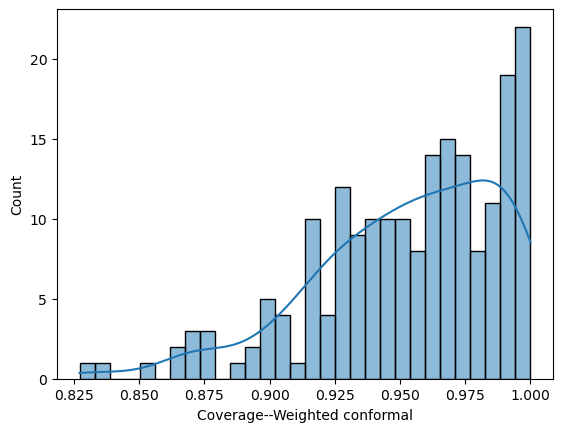

In [11]:
sns.histplot(np.array(coverage).reshape(-1, 1), kde = True, bins = 30, legend=False)
plt.xlabel('Coverage--Weighted conformal')

In [1]:
sns.histplot(np.array(bandwidth).reshape(-1, 1), kde = True,bins = 30, legend=False)
plt.xlabel('Bandwidth--Weighted conformal')

NameError: name 'sns' is not defined

In [28]:
np.sqrt(np.ma.masked_invalid(bandwidth[coverage >= 0.95]).var())

4.391388604434692

In [27]:
np.sqrt(coverage.var())

0.03600934187930062

In [20]:
np.savetxt('Coverage_WC_200.csv', coverage, delimiter=',')
np.savetxt('Bandwidth_WC_200.csv', bandwidth, delimiter=',')